In [118]:
from scipy.integrate import cumtrapz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [119]:
data = pd.read_csv('Nasa_UK_21-22.csv')

In [120]:
# Define the function for RHcrit based on the provided formula
def compute_rh_crit(T):
    T = np.array(T)
    rh_crit = np.zeros_like(T)
    rh_crit[T <= 20] = -0.0026 * T[T <= 20]**3 + 0.160 * T[T <= 20]**2 - 3.13 + 100.0
    rh_crit[T > 20] = 80
    return rh_crit

# Compute RHcrit
data['RHcrit'] = compute_rh_crit(data['TS'])

$$
RH_{\text{crit}} =
\begin{cases}
-0.0026T^3 + 0.160T^2 - 3.13 + 100.0 & \text{when } T(t) \leq 20 \\
80 & \text{when } T(t) > 20
\end{cases}
$$


In [121]:
# Define the parameters
k11 = 1
k12 = 2
A = 1
B = 7
C = 2

p_T = 0.68
p_RH = 13.9
p_C = 66.02
W = 1
SQ = 1
C_decline = 0.1
t_1 = None

$$
k_1 =
\begin{cases}
k_{11} & \text{when } M < 1 \\
k_{12} & \text{when } M \geq 1
\end{cases}
$$


$$
k_2 = \max\left[1-\exp\left(2.3*(M-M_{\text{max}})\right), 0\right]
$$


$$
M_{\text{max}} = A+ B\frac{RH_{\text{crit}}-RH}{RH_{\text{crit}}-100} -C\left(\frac{RH_{\text{crit}}-RH}{RH_{\text{crit}}-100}\right)^2
$$


$$
\frac{dM}{dt} = \frac{k_1k_2}{7* \exp\left(-p_T \ln(T) - p_{RH} \ln(RH) + 0.14W - 0.33SQ + p_C\right)} \quad \text{when } RH(t) \geq RH_{\text{crit}}(t)
$$


$$
\frac{dM}{dt} = C_{\text{decline}}
\begin{cases}
-0.032 & \text{when } t - t_1 \leq 6h \text{, or for nonwood surface }  \\
0 & \text{when } 6h < t - t_1 \leq 24h \\
-0.0016 & \text{when } t - t_1 > 24h
\end{cases} \quad \text{when } RH(t) < RH_{\text{crit}}(t)
$$


In [122]:
time = np.arange(len(data))

In [123]:
# Initialize an empty arrays for dM/dt and M
dMdt = np.zeros(len(data))
M = np.zeros(len(data))

# Iterate over the data to compute dM/dt and M
for i in range(len(data)):
    # Compute M_max at the current time step
    M_max = A + B * (data.loc[i, 'RHcrit'] - data.loc[i, 'RH2M']) / (data.loc[i, 'RHcrit'] - 100) - C * ((data.loc[i, 'RHcrit'] - data.loc[i, 'RH2M']) / (data.loc[i, 'RHcrit'] - 100))**2

    # Compute k1 and k2 at the current time step
    k1 = k11 if M[i-1] < 1 else k12
    k2 = max(1 - np.exp(2.3 * (M[i-1] - M_max)), 0)

    # If this is the start of a period when RH(t) < RHcrit(t), update t_1
    if data.loc[i, 'RH2M'] < data.loc[i, 'RHcrit'] and t_1 is None:
        t_1 = time[i]

    # Calculate the time elapsed since t_1 (in hours, because the data is daily and 1 day = 24 hours)
    elapsed_time = (time[i] - t_1) * 24 if t_1 is not None else 0

    # Use the decline model to compute dM/dt when RH(t) < RHcrit(t)
    if data.loc[i, 'RH2M'] < data.loc[i, 'RHcrit']:
        if elapsed_time <= 6:
            dMdt[i] = -0.032 * C_decline
        elif elapsed_time <= 24:
            dMdt[i] = 0
        elif elapsed_time > 24:
            dMdt[i] = -0.0016 * C_decline
    else:
        # If RH(t) >= RHcrit(t), compute dM/dt using equation (2) and reset t_1
        dMdt[i] = (k1 * k2 / 7) * np.exp(-p_T * np.log(data.loc[i, 'TS']) - p_RH * np.log(data.loc[i, 'RH2M']) + 0.14 * W - 0.33 * SQ + p_C)
        t_1 = None

    # Compute M(t) by integrating dM/dt over time
    M[i] = M[i-1] + dMdt[i] if i > 0 else 0

# Add the new dM/dt and M values to the dataframe
data['dMdt'] = dMdt
data['M'] = M

# Display the first few rows of the data
data.head()

/var/folders/mt/9xr9vc1j62s6yvdx48jm0xlr0000gn/T/ipykernel_58423/316193696.py:12: RuntimeWarning: overflow encountered in exp
  k2 = max(1 - np.exp(2.3 * (M[i-1] - M_max)), 0)


,YEAR,MO,DY,TS,RH2M,Date,RHcrit,dMdt,M
0,2021,1,1,2.48,96.38,1/1/21,97.814406,-0.00320,0.00000
1,2021,1,2,3.64,95.38,1/2/21,98.864542,0.00000,0.00000
2,2021,1,3,3.77,94.62,1/3/21,99.004749,-0.00016,-0.00016
3,2021,1,4,4.30,95.00,1/4/21,99.621682,-0.00016,-0.00032
4,2021,1,5,3.86,96.25,1/5/21,99.104404,-0.00016,-0.00048


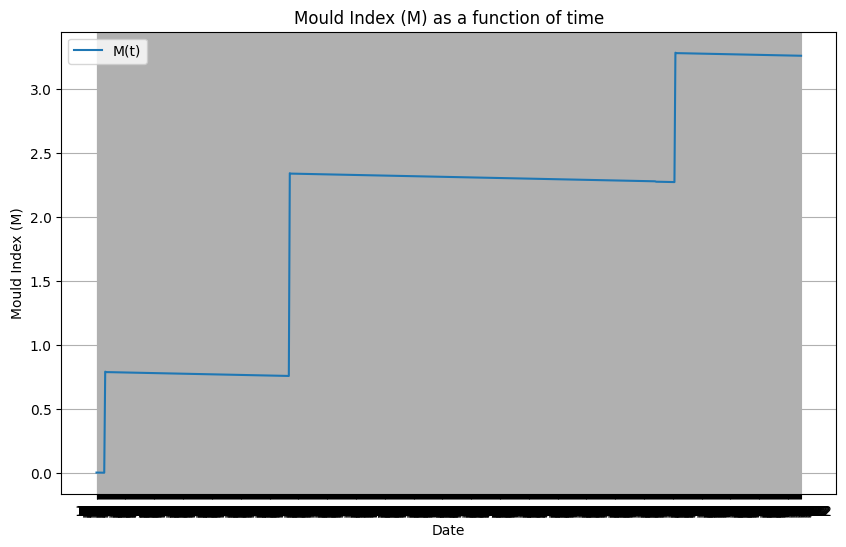

In [124]:
# Plot M as a function of time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['M'], label='M(t)')
plt.xlabel('Date')
plt.ylabel('Mould Index (M)')
plt.title('Mould Index (M) as a function of time')
plt.grid(True)
plt.legend()
plt.show()


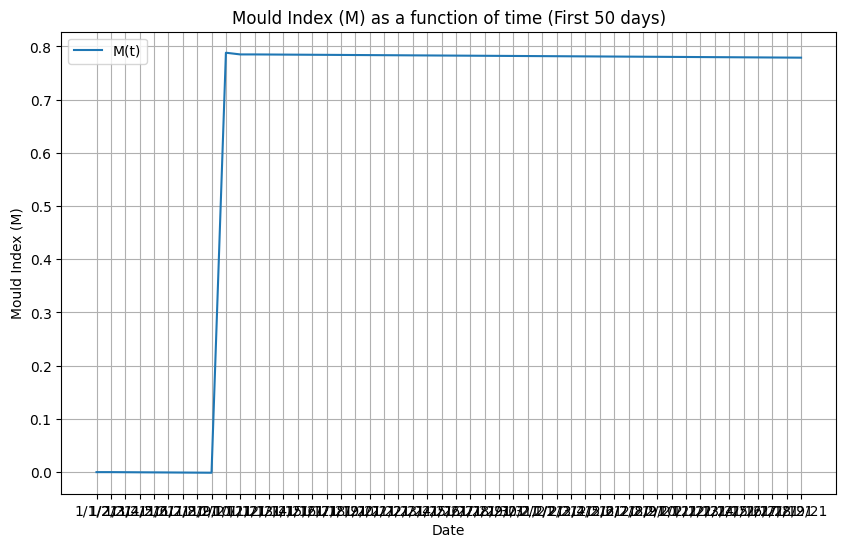

In [125]:
# Plot M as a function of time for the first 50 days
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][:50], data['M'][:50], label='M(t)')
plt.xlabel('Date')
plt.ylabel('Mould Index (M)')
plt.title('Mould Index (M) as a function of time (First 50 days)')
plt.grid(True)
plt.legend()
plt.show()
